# Inverse Design using SCEE

Do to how fast SCEE is, inverse design of power splitting directional couplers can be achieved via an optimizer. This has been implemented and can be used via the `SiPANN.scee_opt` module, speficially the `make_coupler` function. It implements a global optimization, then a local optimization to best find the ideal coupler.

This is done by defining the length of the coupler and various control points along the coupler as parameters that our optimizer can choose that result in a $\kappa$ closest to $\kappa_{goal}$. The coupler is then defined using the control points plugged into a Bezier Curve. Note that the Bezier curve defined by the control points is the gap between waveguides, not the geometry of the waveguides themselves. However, since each of these directional couplers is symmetric the inner boundary of the waveguides are just half of the gap.

Further, for our objective function, we compute $\kappa$ for a sweep of wavelength points using SCEE, and then calculate the MSE by comparing it to $\kappa_{goal}$. Various constraints are also put on the coupler, like ensuring the edges of the coupler are far enough apart and making sure there's no bends that are too sharp. To learn more about the process, see [INSERT PAPER WHEN PUBLISHED].

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from SiPANN import scee_opt, scee

def pltAttr(x, y, title=None, legend='upper right', save=None):
    if legend is not None:
        plt.legend(loc=legend)
    plt.xlabel(x)
    plt.ylabel(y)
    if title is not None:
        plt.title(title)
    if save is not None:
        plt.savefig(save)

## Wavelength Sweep

Most of the defaults parameters for `SiPANN.scee_opt.make_coupler` have been set because they work well, so if you don't know what you're doing, it's generally best to stick with them. Here we make a coupler with 25% of the light coming out of the cross port. It will return an instance of `SiPANN.scee.GapFuncSymmetric`, the control points chosen, and the final length of the coupler.

The number of points passed into `waveSweep` is the one that affects how long the optimizer takes the most. We pass in 2 points. This will cause the optimizer to use the endpoints of our wavelength sweep when evaluating the objective function. This is generally sufficient since the response is usually either increasing or decreasing everywhere, so trying to push the endpoints to our desired ratio is enough.

LOCAL, MSE: 0.0267, Mean currK: 0.2864:  50%|█████     | 15001/30000 [42:58<38:09,  6.55it/s]   /home/contagon6/Documents/SiPANN/SiPANN/scee.py:417: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  z_dist = quad(arcFomula, self.zmin, self.zmax)[0] + extra_arc
/home/contagon6/Documents/SiPANN/SiPANN/scee.py:425: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  mag[i] = trig( np.pi * quad(f_mag, self.zmin, self.zmax)[0] / wavelength[i] )
/home/contagon6/Documents/SiPANN/SiPANN/scee.py:428: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  phase[i] = np.pi * quad(f_phase, self.zmin, self.zmax)[0] / wavelength[i] + 2*np.pi*neff[i]*z_dist/wavelength[i] + offset
/home/contagon6/Documents/SiPANN/SiPANN/scee_opt.py:257: RuntimeWarning: invalid value encountered in less
  mse += np.sum(gap['f'](np.linspace(0,g[0],100)) < 

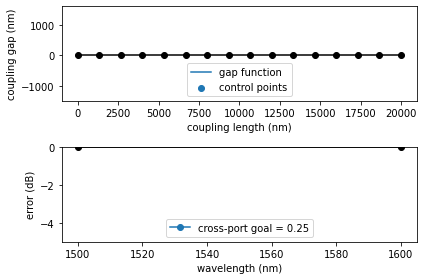

In [16]:
width = 500
thickness = 220
coupler, gap_pts, length = scee_opt.make_coupler(goalK=.25, verbose=1, 
                                                 width=width, thickness=thickness, 
                                                 waveSweep=np.array([1500,1600]), maxiter=15000)

We can easily save it to an npz file for later use using `SiPANN.scee_opt.save_coupler`

In [3]:
scee_opt.save_coupler(width, thickness, gap_pts, length, "split_25_75.npz")

And then reload it using the `SiPANN.scee_opt.load_coupler`. This will return us an instance of `SiPANN.scee.GapFuncSymmetric`.

In [10]:
coupler, length = scee_opt.load_coupler("split_25_75.npz")

And we'll check what it looks like and make sure it performs as we anticipated.

In [11]:
coupler.gds(view=True,extra=0,units='microns')

![coupler](InverseDesign_files/coupler.png)

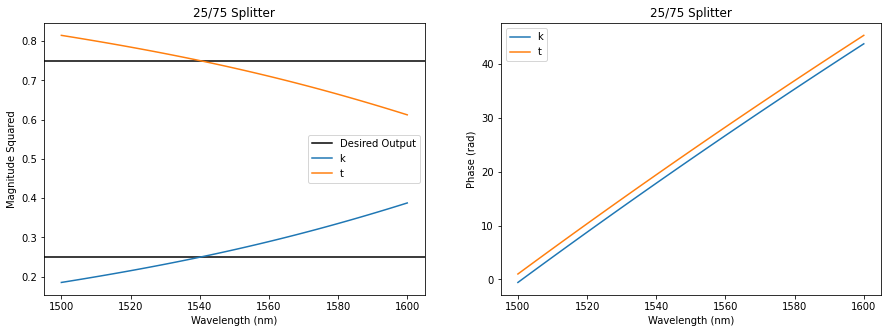

In [12]:
wavelength = np.linspace(1500, 1600, 100)
k = coupler.predict((1,4), wavelength)
t = coupler.predict((1,3), wavelength)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.axhline(.25, c='k', label="Desired Output")
plt.axhline(.75, c='k')
plt.plot(wavelength, np.abs(k)**2, label='k')
plt.plot(wavelength, np.abs(t)**2, label='t')
pltAttr('Wavelength (nm)', 'Magnitude Squared', '25/75 Splitter', legend='best')
plt.subplot(122)
plt.plot(wavelength, np.unwrap(np.angle(k)), label='k')
plt.plot(wavelength, np.unwrap(np.angle(t)), label='t')
pltAttr('Wavelength (nm)', 'Phase (rad)', '25/75 Splitter', legend='best')

For your convenience, this has been done for a variety of splitting ratios already and they all can be loaded using `SiPANN.scee_opt.premade_coupler`. To learn more about how to use that see the tutorial on Premade Couplers via Inverse Design.

## Single Wavelength

If we desire a specific wavelength to have a ratio, we can achieve this by making `waveSweep` only have one element. This causes only a single wavelength to be optimized (and a solution is generally found very quickly). This enforces nothing on any other wavelengths, so it's possible that it will be significantly different than the desired ratio even at close wavelengths.

For an example, we show this for $\lambda=1530nm$ and a ratio of 45%.

LOCAL, MSE: 0.1523, Mean currK: 0.1832:  18%|█▊        | 10975/60000 [18:09<1:31:59,  8.88it/s] 

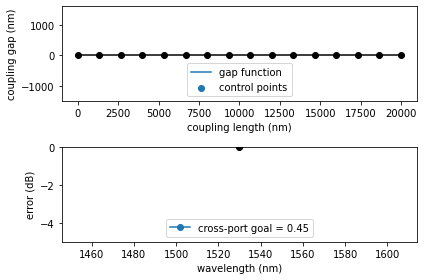

In [11]:
width = 500
thickness = 220
coupler, gap_pts, length = scee_opt.make_coupler(goalK=.45, verbose=1, 
                                                 width=width, thickness=thickness, maxiter=30000,
                                                 waveSweep=np.array([1530]))
scee_opt.save_coupler(width, thickness, gap_pts, length, "split_45_55_1530.npz")

In [13]:
coupler, length = scee_opt.load_coupler("split_45_55_1530.npz")
coupler.gds(view=True,extra=0,units='microns')

![splitter](InverseDesign_files/splitter.png)

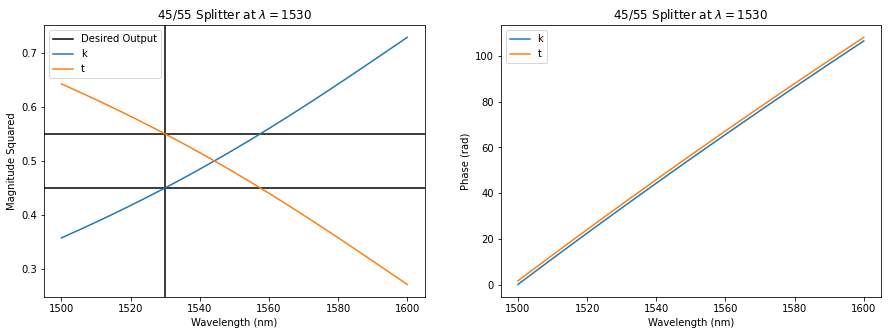

In [14]:
wavelength = np.linspace(1500, 1600, 100)
k = coupler.predict((1,4), wavelength)
t = coupler.predict((1,3), wavelength)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.axhline(.45, c='k', label="Desired Output")
plt.axhline(.55, c='k')
plt.axvline(1530, c='k')
plt.plot(wavelength, np.abs(k)**2, label='k')
plt.plot(wavelength, np.abs(t)**2, label='t')
pltAttr('Wavelength (nm)', 'Magnitude Squared', '45/55 Splitter at $\lambda=1530$', legend='best')
plt.subplot(122)
plt.plot(wavelength, np.unwrap(np.angle(k)), label='k')
plt.plot(wavelength, np.unwrap(np.angle(t)), label='t')
pltAttr('Wavelength (nm)', 'Phase (rad)', '45/55 Splitter at $\lambda=1530$', legend='best')

If you'd like this tutorial as a jupyter notebook, it can be found on github, [here](https://github.com/contagon/SiPANN/blob/master/examples/Tutorials/InverseDesign.ipynb)